In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

/tmp/ipykernel_19760/1195567528.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print('Текущее устройство - Gpu')
# else:
#     print('Текущее устройство - Cpu')
device = torch.device("cpu")

In [8]:
names = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price',
         'volume', 'close_time', 'quote_time', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore']
#Open data and drop useless columns
data = []
filenames = []
for filename_1 in os.listdir('BTC'):
    for filename_2 in os.listdir('BTC/' + filename_1):
        df = pd.read_csv('BTC/' + filename_1 + '/' + filename_2)
        df.columns = names
        df.drop(columns=['open_time', 'close_time', 'quote_time', 'ignore'], axis=1, inplace=True)
        data.append(df)
        
#Make 1 big dataframe and save this as .csv
big_mommy = pd.concat(data)
big_mommy.to_csv('proccessed_BTC_2020-2023.csv', index=False)

In [3]:
df = pd.read_csv('proccessed_BTC_2020-2023.csv')
print(df.head(2))

   open_price  high_price  low_price  close_price      volume  count  \
0    57545.06    57549.99   57421.05     57542.62  139.034744   4106   
1    57542.64    57719.82   57542.62     57703.10   84.742481   2488   

   taker_buy_volume  taker_buy_quote_volume  
0         62.627884            3.600659e+06  
1         39.257872            2.262959e+06  


In [4]:
#Получаем входные данные и метки
#(модель предсказывает на 6 часов вперед используя прошлые 48 часов, интервал - 1 минута)
input = df.copy()
input = input.iloc[:-360]
labels = df.copy()['close_price'].iloc[3340:]

#Make 0 to prev
with_zero_columns = ['volume', 'count', 'taker_buy_volume']
for el in with_zero_columns:
    input[el] = input[el].replace(0, method='ffill')
print(input.min())

open_price                3810.00000
high_price                3900.00000
low_price                 3782.13000
close_price               3810.78000
volume                       0.25970
count                       24.00000
taker_buy_volume             0.02756
taker_buy_quote_volume       0.00000
dtype: float64


/tmp/ipykernel_19760/4283738994.py:10: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  input[el] = input[el].replace(0, method='ffill')


In [5]:
#Feature engineering
#Арун=[(period-after_max)/period]
def aroon(df, column_name, start, end):
    max_period_index = 0
    min_period_index = 0
    aroon_up = []
    aroon_down = []
    period = end - start
    
    for i in range(len(df) - period):
        buff_data = df[column_name][start:end][::-1]

        max_period_index =  buff_data.idxmax() - i
        aroon_up.append((period - max_period_index) / period)

        min_period_index = buff_data.idxmin() - i
        aroon_down.append((period - min_period_index) / period)

        start += 1
        end += 1
    return (aroon_up, aroon_down)

In [115]:
#Test features
test_df = pd.DataFrame({'1':[1, 2, 3, 4, 5]})
(aroon_up, aroon_down) = aroon(test_df, '1', 0, 2)
print(f'Aroon up: {aroon_up}')
print(f'Aroon down: {aroon_down}')

Aroon up: [0.5, 0.5, 0.5]
Aroon down: [1.0, 1.0, 1.0]


In [6]:
#Make new features
input = df.copy()
input = input.iloc[:-360]

(aroon_up, aroon_down) = aroon(input, 'close_price', 0, 360)
input = input.iloc[360:]
input['aroon_up'] = aroon_up
input['aroon_down'] = aroon_down

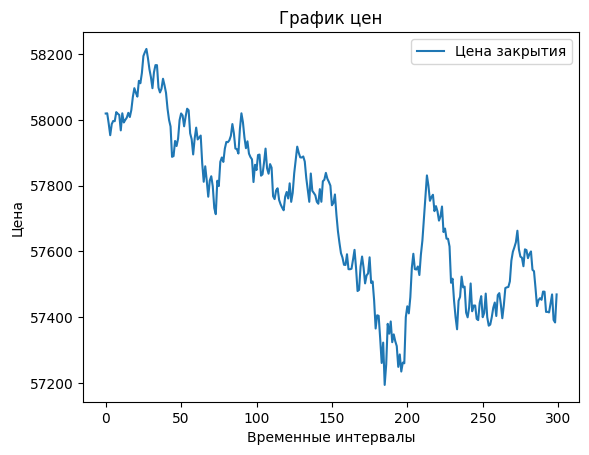

In [7]:
import matplotlib.pyplot as plt

# Строим график
plt.plot([el for el in range(300)], input['close_price'][:300], label='Цена закрытия')

# Добавляем заголовок и метки осей
plt.title('График цен')
plt.xlabel('Временные интервалы')
plt.ylabel('Цена')
# plt.yscale('log')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()

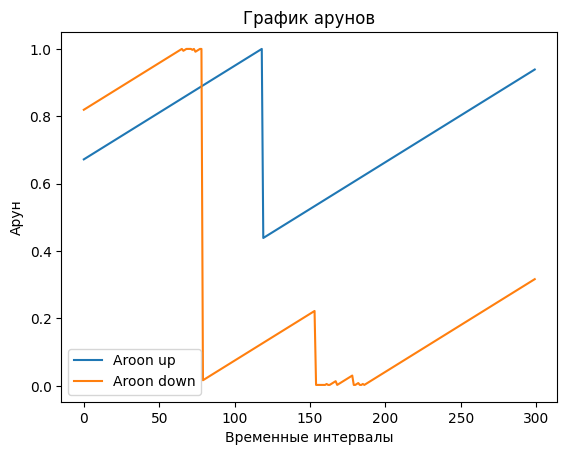

In [8]:
# Строим график
plt.plot([el for el in range(300)], input['aroon_up'][:300], label='Aroon up')
plt.plot([el for el in range(300)], input['aroon_down'][:300], label='Aroon down')

# Добавляем заголовок и метки осей
plt.title('График арунов')
plt.xlabel('Временные интервалы')
plt.ylabel('Арун')
# plt.yscale('log')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()

In [7]:
#Normalization
input.drop(['close_price', 'taker_buy_quote_volume'], axis=1, inplace=True)

need_normalize = ['volume', 'count', 'taker_buy_volume']
for el in need_normalize:
    input[el] = (input[el] - input[el].mean()) / input[el].std()

In [16]:
#Data loader
class Step_dataset(Dataset):
    def __init__(self, input, labels, input_queue_size, labels_queue_size, step=1):
        self.input = []
        self.labels = []
        input_idx_buff = input_queue_size
        labels_idx_buff = labels_queue_size

        while input_idx_buff <= len(input):
            self.input.append(input.iloc[input_idx_buff-input_queue_size:input_idx_buff].values)
            input_idx_buff += step
        print('Length of input data: ' + str(len(self.input)))
        while labels_idx_buff <= labels.size:
            self.labels.append(labels.iloc[labels_idx_buff-labels_queue_size:labels_idx_buff].values)
            labels_idx_buff += step
        print('Length of labels: ' + str(len(self.labels)))

        #To tensors
        self.input = torch.tensor(np.array(self.input), dtype=torch.float32)
        self.labels = torch.tensor(np.array(self.labels), dtype=torch.float32)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, idx):
        return self.input[idx], self.labels[idx]

custom_dataset = Step_dataset(input, labels, 2880, 360, 180)
#list: 43.2
#numpy: 38.2
#simple values: 37.9
#should use numpy to tensor except list: 1.5

Length of input data: 11655
Length of labels: 11655


In [19]:
from torch.utils.data.dataset import random_split

#60% - training
#20% - validate
#20% - testing
train_dataset_size = int(len(custom_dataset) * 0.6)
validate_dataset_size = int(len(custom_dataset) * 0.2)
testing_dataset_size = len(custom_dataset) - train_dataset_size- validate_dataset_size
train_subset, validate_subset, testing_subset = random_split(custom_dataset, [train_dataset_size, validate_dataset_size, testing_dataset_size])
print(len(train_subset))
print(len(validate_subset))
print(len(testing_subset))
print(f'Train batches: {len(train_subset) / 128}')
print(f'Validate batches: {len(validate_subset) / 128}')
print(f'Testing batches: {len(testing_subset) / 128}')
train_dataloader = DataLoader(train_subset, batch_size=128, shuffle=True)
validate_dataloader = DataLoader(validate_subset, batch_size=128, shuffle=True)
testing_dataloader = DataLoader(testing_subset, batch_size=128, shuffle=True)
print(f'Train real batches: {len(train_dataloader)}')
print(f'Validate real batches: {len(validate_dataloader)}')
print(f'Testing real batches: {len(testing_dataloader)}')

6993
2331
2331
Train batches: 54.6328125
Validate batches: 18.2109375
Testing batches: 18.2109375
Train real batches: 55
Validate real batches: 19
Testing real batches: 19


In [14]:
#Parametric relu
class PReLU(nn.Module):
    def __init__(self, num_parameters=1, init=0.25):
        super(PReLU, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor(num_parameters).fill_(init))

    def forward(self, x):
        pos = torch.relu(x)
        neg = self.alpha * ((x - torch.abs(x)) * 0.5)
        return pos + neg

#Модель 1
#Input shape = (x, 2880, 8)
#Labels shape = (y, 360)
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        # 1-й слой: входные данные, размерность 12
        self.flatten = nn.Flatten()
        self.linear_prelu_stack = nn.Sequential(
            nn.Linear(2880 * 8, 256),
            # 2-й слой: 64 нейрона, функция активации 'relu'
            PReLU(num_parameters=256),
            # nn.ReLU(),
            # 3-й слой: 32 нейрона, функция активации 'relu'
            nn.Linear(256, 128),
            # nn.ReLU(),
            PReLU(num_parameters=128),
            # 4-й слой: 16 нейронов, без функции активации, 1 выход
            nn.Linear(128, 128),
            # nn.ReLU(),
            PReLU(num_parameters=128),
            nn.Linear(128, 360)
        )

    def forward(self, x):
        # Прямой проход через слои
        x = self.flatten(x)
        x = self.linear_prelu_stack(x)
        return x
    
def validate(model, validate_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validate_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    average_loss = total_loss / len(validate_loader)
    return average_loss

class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, loss):
        if self.best_score is None:
            self.best_score = loss
        elif loss > self.best_score - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = loss
            self.counter = 0

        return self.early_stop

In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = Model_1()
print(model)
criterion = nn.L1Loss()#nn.MSELoss()#nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01) #RMSprop слишком инертен
model.to(device)
epochs = 300
history = []
early_stopping = EarlyStopping(patience=20, delta=40)

# Конфигурирование ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
# Пример цикла обучения
best_loss = float('inf')  # Инициализация лучшей потери

#Обучение
for epoch in range(epochs):
    model.train(True)
    running_loss = 0.0
    for inp, targ in train_dataloader:
        outputs = model(inp)
        loss = criterion(outputs, targ)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Валидация и обновление learning rate
        val_loss = validate(model, validate_dataloader, criterion)

        # Сохранение лучшей модели
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model_0.1.1.pth')
    
    average_loss = running_loss / len(train_dataloader)
    # Проверка EarlyStopping
    if early_stopping(average_loss):
        print("Early stopping")
        break
    history.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss train: {average_loss}, Loss validate: {val_loss}")
    lr_scheduler.step(val_loss)

print("Обучение завершено")#71

Model_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_prelu_stack): Sequential(
    (0): Linear(in_features=23040, out_features=256, bias=True)
    (1): PReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): PReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): PReLU()
    (6): Linear(in_features=128, out_features=360, bias=True)
  )
)


/home/anselzuz/ai/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/300, Loss train: 99378.51390269886, Loss validate: 8468.830386513158
Epoch 2/300, Loss train: 4078.8533247514206, Loss validate: 2037.2279887952302
Epoch 3/300, Loss train: 2298.155488725142, Loss validate: 5688.753546463816
Epoch 4/300, Loss train: 2619.5608520507812, Loss validate: 1947.9820363898027
Epoch 5/300, Loss train: 2254.48134765625, Loss validate: 1529.1312063116777
Epoch 6/300, Loss train: 1652.2780439897017, Loss validate: 1271.6781648334704
Epoch 7/300, Loss train: 2029.269064053622, Loss validate: 4764.366930509868
Epoch 8/300, Loss train: 2003.58427734375, Loss validate: 1189.8526482833058
Epoch 9/300, Loss train: 2134.530657404119, Loss validate: 3379.279296875
Epoch 10/300, Loss train: 2137.4992065429688, Loss validate: 3144.7665244654604
Epoch 11/300, Loss train: 1384.3231889204546, Loss validate: 1138.3698923211348
Epoch 12/300, Loss train: 1520.5104469992898, Loss validate: 1273.5969398900081
Epoch 13/300, Loss train: 1712.3297773881393, Loss validate: 304

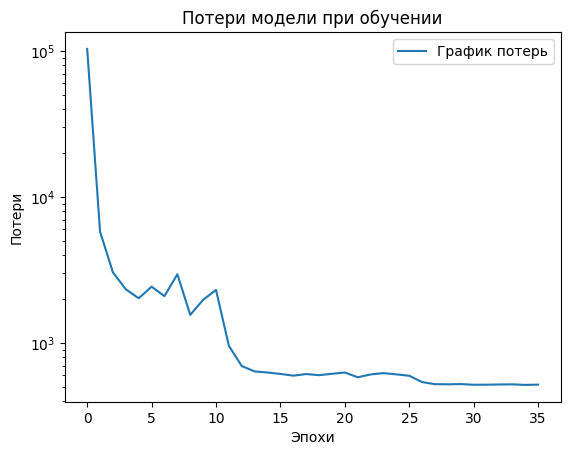

In [21]:
import matplotlib.pyplot as plt

# Строим график
plt.plot([el for el in range(len(history))], history, label='График потерь')

# Добавляем заголовок и метки осей
plt.title('Потери модели при обучении')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.yscale('log')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()

In [ ]:
#Epoch 99/100, Loss train: 11740.796759588067, Loss validate: 17755.860034839527
#Epoch 45/300, Loss train: 11782.044504616477, Loss validate: 17750.228568412163
#Epoch 121/300 Loss train: ~14540.1045404607, Loss validate: 13025.983556798987
#Перемешивание данных
#Epoch 40/300, Loss train: 12420.102796519886, Loss validate: 12372.684200802365
#Epoch 46/300, Loss train: 12455.469833096591, Loss validate: 12360.698638091217 Dropout=0.2
#Epoch 84/300, Loss train: 12411.495880681818, Loss validate: 12361.870513091217 Dropout=0.5 /После функции активации
#Epoch 94/300, Loss train: 12410.738893821022, Loss validate: 12362.056059966217 Dropout=0.5 /До функции активации + изменены patience
#Можно сделать вывод о том, что dropout увеличивает только количество эпох для наступления переобучения.
#аким образом его следует использовать только в том случае, если переобучение наступает слишком быстро.

#Убрав бессмысленный большой параметр и использовав prelu, получилось следующее:
#Epoch 18/300, Loss train: 536.1260725541548, Loss validate: 477.21559926625844
#С простым relu:
#Epoch 21/300, Loss train: 448.62574157714846, Loss validate: 477.84757500725823
#=> какого-то "умертвления" нейронов в данной модели не происходит
#С нормализацией данных + prelu, поскольку нормализованные данные мб < 0
#Epoch 22/300, Loss train: 456.11132562810724, Loss validate: 476.1366717364337
#Epoch 34/300, Loss train: 466.57342917702414, Loss validate: 439.2744349429482 (patience = 12)
#Pytorch shuffle
#Epoch 51/300, Loss train: 481.93182650479406, Loss validate: 509.88593974866365

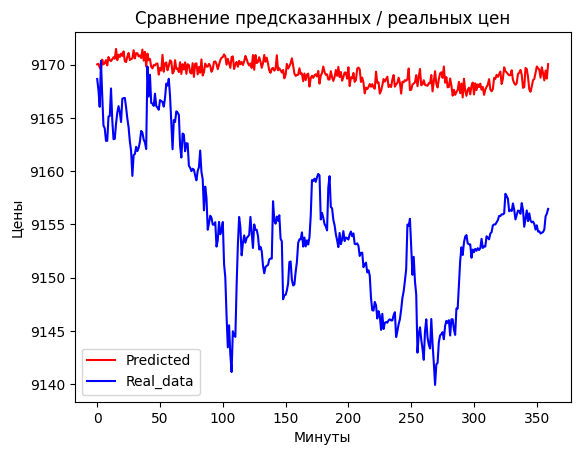

In [25]:
import matplotlib.pyplot as plt

criterion = nn.L1Loss()
loaded_model = Model_1()
loaded_model.load_state_dict(torch.load('best_model_0.1.1.pth'))
loaded_model.eval()
output = None
test = None

stop_count = 0
for test_input, test_labels in testing_dataloader.dataset:
    batched_input = test_input.unsqueeze(0)
    output = loaded_model(batched_input)
    test = test_labels
    stop_count += 1
    if  stop_count > 0:
        break

plt.plot([el for el in range(360)], output.squeeze().tolist()[:360], color='red', label='Predicted')
plt.plot([el for el in range(360)], test.tolist()[:360], color='blue', label='Real_data')
plt.title('Сравнение предсказанных / реальных цен')
plt.xlabel('Минуты')
plt.ylabel('Цены')
# #Логарифмируем графики
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()